In [13]:
import pandas as pd

df_dance = pd.read_csv('../data/dataset_0.csv')
df_idle = pd.read_csv('../data/dataset_1.csv')
df_walk = pd.read_csv('../data/dataset_2.csv')
df_run = pd.read_csv('../data/dataset_3.csv')
df_spin = pd.read_csv('../data/dataset_4.csv')

In [14]:
df = pd.concat([df_dance, df_idle, df_walk, df_run, df_spin])
df.rename(columns={'Set': 'Label'}, inplace=True)
df.drop(columns=['OrientationX_sin', 'OrientationX_cos', 'OrientationY_sin', 'OrientationY_cos', 'OrientationZ_sin', 'OrientationZ_cos'], inplace=True) #Let´s try to use only accelerometer and gyroscope at least for now

In [15]:
df.head()

,Label,AnimIndex,AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ
0,Dance,0,-0.029801,0.106064,0.015994,0.164124,-0.018282,-0.041787
1,Dance,0,39.974822,-103.035792,-41.127805,9.177075,0.814839,0.038732
2,Dance,0,39.993631,-103.234790,-40.895767,8.912522,0.704715,-0.185318
3,Dance,0,-34.561648,103.504571,40.498262,-0.039133,-1.434110,-0.152650
4,Dance,0,0.560703,-4.028138,-0.039327,-0.488945,-0.616965,0.132907


In [16]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [17]:
import numpy as np

def create_sliding_windows(data, label_col, window_size, step_size):
    sequences = []
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        sequences.append(window[feature_cols].values)
        label = window[label_col].mode()[0]
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 100
step_size = 25
X, y = create_sliding_windows(df, label_col='Label', window_size=window_size, step_size=step_size)

In [18]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(df['AnimIndex'].unique(), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_data = df[df['AnimIndex'].isin(train_indices)]
val_data = df[df['AnimIndex'].isin(val_indices)]
test_data = df[df['AnimIndex'].isin(test_indices)]

X_train, y_train = create_sliding_windows(train_data, label_col='Label', window_size=window_size, step_size=step_size)
X_val, y_val = create_sliding_windows(val_data, label_col='Label', window_size=window_size, step_size=step_size)
X_test, y_test = create_sliding_windows(test_data, label_col='Label', window_size=window_size, step_size=step_size)

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [20]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(window_size, len(feature_cols)), return_sequences=False),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 22,661
Trainable params: 22,661
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
106/106 [==============================] - 3s 21ms/step - loss: 1.0301 - accuracy: 0.6146 - val_loss: 0.8526 - val_accuracy: 0.7147
Epoch 2/10
106/106 [==============================] - 2s 18ms/step - loss: 0.8591 - accuracy: 0.6324 - val_loss: 0.7803 - val_accuracy: 0.7163
Epoch 3/10
106/106 [==============================] - 2s 18ms/step - loss: 0.7684 - accuracy: 0.7167 - val_loss: 0.6058 - val_accuracy: 0.8257
Epoch 4/10
106/106 [==============================] - 2s 19ms/step - loss: 0.6831 - accuracy: 0.7735 - val_loss: 0.5771 - val_accuracy: 0.8621
Epoch 5/10
106/106 [==============================] - 2s 18ms/step - loss: 0.6569 - accuracy: 0.7928 - val_loss: 0.5817 - val_accuracy: 0.8605
Epoch 6/10
106/106 [==============================] - 2s 18ms/step - loss: 0.6076 - accuracy: 0.8135 - val_loss: 0.5169 - val_accuracy: 0.8796
Epoch 7/10
106/106 [==============================] - 2s 18ms/step - loss: 0.5598 - accuracy: 0.8281 - val_loss: 0.4728 - val_accuracy: 0.8796

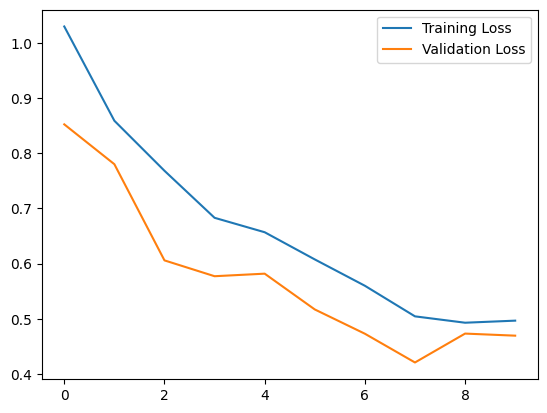

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

13/13 [==============================] - 0s 7ms/step - loss: 1.1806 - accuracy: 0.6585
Test Loss: 1.1806, Test Accuracy: 0.6585


In [26]:
model.save('../models/imu_rnn_classifier.keras')